# Data Science Class Project (100 points)

Due December 20, 11:59pm 

Turn in one html file on canvas the same way you have done for the exam and homework assignments.

# Name: <span style='color:blue'>Teresa Duong <span style>

# Project Title: <span style='color:blue'>Predicting Brightness of Fluorescent Proteins<span style>



# Introduction: (15 points)

Please make sure your introduction includes the following information:

* Motivation: Why you chose this topic and dataset. (5)
* Dataset:  Where you obtained the dataset and the information it contains. (5)
* Goal(s): What are the goals of your project? (5)

<span style='color:blue'> 
Fluorescent protein development is a current topic in research which has many uses in imaging for medical as well as academic purposes. Fluorescent protein brightness is a feature of great interest, as many structures in a cell autofluoresce, making a bright fluorescent protein with high signal to noise ratio important for visualizing. Many fluorescent proteins are developed by a process called random mutagenesis which uses a low fidelity polymerase to introduce random mutations into the gene encoding for a protein; these mutations are screened for increases in brightness. Rational mutagenesis on the other hand is the investigation of specific mutations guided by intuition and data. Though there are projects currently exploring the sequence to brightness relationship for more rational mutagenesis, it would also be interesting to see if common features can be found between high brightness proteins as well and learn more about these high brightness proteins holistically also from physical properties.
<br>
<br>
The dataset used is the Fluorescent Protein Table from the FPBase online database which catalogs user submitted proteins and their fluorescence properties (1). Available properties of the proteins include their maximum excitation and emission wavelengths, extinction coefficient, and oligomerization type among others. These properties are sourced from literature in which these properties are experimentally determined and pertain to proteins of various colors and lineages. The size of the dataset is 1110 entries, however, after removing missing value data, 553 entries remain for use in this project. 
<br>
<br>
The goal of this project was to evaluate whether photophysical properties could be used to classify fluorescent proteins by molecular brightness and to compare the performance of several nonlinear machine learning models for this task. This project also hopes to identify potential important features to protein brightness and learn more about the nature of the nonlinear boundaries by which low and high brightness proteins can be distinguished.

<span style>

# Methods: (15 points)

Briefly describe:

* What are the methods you will use? (5)
* Justify why you chose these methods for your particular data set. (5)
* What are the free parameters and hyperparameters in those methods and how will you choose and/or optimize them? (5)

<span style='color:blue'> 
The methods used include Principal Component Analysis (PCA) and classification models including a linear regression baseline model (with a softmax cost function), K-Nearest Neighbor modeling, Support Vector Machine modeling, and XGBoost modeling (ensemble decision trees). K-fold cross validation will train the models on several sets of shuffled training data to reduce overfitting. PCA will be performed to predict important features that correlate with variations in protein brightness. Prior to modeling also, dataset class imbalance will be addressed by oversampling the minority class (high brightness proteins), categorical variables will be encoded to numerical values, and the dataset will be standard scaled.  
<br>
<br>
Linear regression was used as a baseline model to assess the linearity or nonlinearity of protein brightness. K-nearest neighbors modeling (KNN) was chosen because local neighborhoods in the feature space were predicted to be somewhat conserved, as fluorescent proteins with similar brightness were predicted to share other photophysical properties, due to strong structure-function arguments in protein chemistry. Support Vector Machines modeling was chosen because margin-based classifiers suit nonlinear decision boundaries, which were expected in this dataset since brightness values in FPBase are calculated as the multiplication of extinction coefficient and quantum yield. XGBoost to test the effect of the boosting on addressing our class imbalance in addition to the oversampling since XGBoost emphasizes misclassified samples during training, allowing the model to focus on underrepresented high-brightness proteins.
<br>
<br>
No hyperparameters were set for the linear regression baseline model, and default regularization was used. The hyperparameters for the K-Nearest Neighbors model are the number of neighbors, “p”, and weight type. The number of neighbors and ‘p’ were optimized using GridSearchCV. Weights were set to be distance-based since closer data points in this context are predicted to be physically more similar proteins. The parameters for the Support Vector Machines model are 'C' the regularization strength, 'gamma', and the kernel. C and gamma were optimized by GridSearch CV, but the kernel was set to ‘rbf’ rather than linear in order to explore non-linear regression for this assignment. The hyperparameters for the XGBoost model are the model learning rate, the maximum depth of decision trees, the number of estimators and the subsample size. These hyperparameters were optimized using GridSearchCV.

<span style>

# Results: (55 points)
Report your results using primarily tables, figures, and text blocks that describe them.  Label axis, units, and legends. Include all code used to generate the figures and tables.  Make sure you clearly state what you did to generate the data in each figure/table. You must analyze your features and build models with methods that are nonlinear.

* Analysis of data. (40)
* Figure quality. (15)

In [1]:
import pandas as pd
import sklearn
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [2]:
df = pd.read_csv("C:\\Users\\13012\\DS_CHE\\Project\\fpbase_proteins.csv")
df_bright = df[df['Brightness'].notna()]
cols_drop = ['State', 'pKa', 'Maturation (min)', 'Lifetime (ns)', 'Aliases' ]
df_final= df_bright.drop(columns=cols_drop)
df_final = df_final.dropna()

print(df_final.shape)
display(df_final.head(10))

(553, 11)


,Name,Ex max (nm),Em max (nm),Stokes Shift (nm),Extinction Coefficient,Quantum Yield,Brightness,Oligomerization,Molecular Weight (kDa),Year,Switch Type
9,aacuGFP1,478.0,502.0,24.0,36900.0,0.61,22.51,t,25.70,2008.0,b
10,aacuGFP2,502.0,513.0,11.0,93900.0,0.71,66.67,t,26.09,2008.0,b
11,AausFP1,504.0,510.0,6.0,170000.0,0.97,164.90,d,25.72,2019.0,b
15,AausGFP,398.0,503.0,105.0,29000.0,0.73,21.17,d,27.45,2019.0,b
17,aceGFP,480.0,505.0,25.0,50000.0,0.55,27.50,m,26.77,2010.0,b
25,aeurGFP,504.0,515.0,11.0,145700.0,0.67,97.62,t,26.02,2008.0,b
26,afraGFP,494.0,503.0,9.0,100800.0,0.61,61.49,t,25.69,2008.0,b
31,&alpha;GFP,397.0,506.0,109.0,30000.0,0.79,23.70,d,26.80,1996.0,b
33,amFP486,458.0,486.0,28.0,40000.0,0.24,9.60,t,25.32,1999.0,b
48,amilFP513,504.0,513.0,9.0,75200.0,0.67,50.38,t,25.98,2007.0,b



<span style='color:blue'> 
Features containing high amounts of missing values ('State', 'pKa', 'Maturation (min)', 'Lifetime (ns)', 'Aliases') were dropped from the dataset. Remaining observations with missing values were dropped as well. 553 observations remain for modeling.
<span style>


## Classes of High and Low Brightness

Molecular brightness is calculated as the product of Extinction Coefficient and Quantum Yield, as stated on the FPbase website.  
Enhanced GFP (EGFP) is known as the gold standard of fluorescent proteins, however, it has a moderate level of brightness that recent proteins have seeked to improve. [1]

In [3]:
df_final[df_final['Name'] == 'EGFP']
#df_final.sort_values('Brightness', ascending=False).head()


,Name,Ex max (nm),Em max (nm),Stokes Shift (nm),Extinction Coefficient,Quantum Yield,Brightness,Oligomerization,Molecular Weight (kDa),Year,Switch Type
240,EGFP,488.0,507.0,19.0,55900.0,0.6,33.54,wd,26.94,1996.0,b


In [4]:
def brightness_class(brightness):
    if brightness < 33.54:
        return 'Low'
    else:
        return 'High'

df_final['Brightness Class'] = df_final['Brightness'].apply(brightness_class)
df_final.head(10)

,Name,Ex max (nm),Em max (nm),Stokes Shift (nm),Extinction Coefficient,Quantum Yield,Brightness,Oligomerization,Molecular Weight (kDa),Year,Switch Type,Brightness Class
9,aacuGFP1,478.0,502.0,24.0,36900.0,0.61,22.51,t,25.70,2008.0,b,Low
10,aacuGFP2,502.0,513.0,11.0,93900.0,0.71,66.67,t,26.09,2008.0,b,High
11,AausFP1,504.0,510.0,6.0,170000.0,0.97,164.90,d,25.72,2019.0,b,High
15,AausGFP,398.0,503.0,105.0,29000.0,0.73,21.17,d,27.45,2019.0,b,Low
17,aceGFP,480.0,505.0,25.0,50000.0,0.55,27.50,m,26.77,2010.0,b,Low
25,aeurGFP,504.0,515.0,11.0,145700.0,0.67,97.62,t,26.02,2008.0,b,High
26,afraGFP,494.0,503.0,9.0,100800.0,0.61,61.49,t,25.69,2008.0,b,High
31,&alpha;GFP,397.0,506.0,109.0,30000.0,0.79,23.70,d,26.80,1996.0,b,Low
33,amFP486,458.0,486.0,28.0,40000.0,0.24,9.60,t,25.32,1999.0,b,Low
48,amilFP513,504.0,513.0,9.0,75200.0,0.67,50.38,t,25.98,2007.0,b,High


Class distribution:
Brightness Class
Low     337
High    216
Name: count, dtype: int64


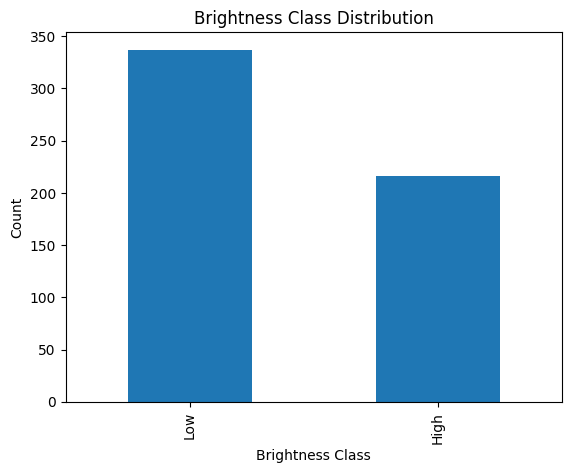

In [5]:
class_counts = df_final['Brightness Class'].value_counts()
print("Class distribution:")
print(class_counts)
class_counts.plot(kind='bar', title='Brightness Class Distribution', xlabel='Brightness Class', ylabel='Count')
plt.show()

<span style='color:blue'> 
A class balance exists betwen 'High' brightness proteins (203) and 'Low' brightness proteins (332).
This may be due to the recency of brighter developed fluorescent proteins.
<span style>

Histograms of Feature Frequencies for High and Low Brightness Classes

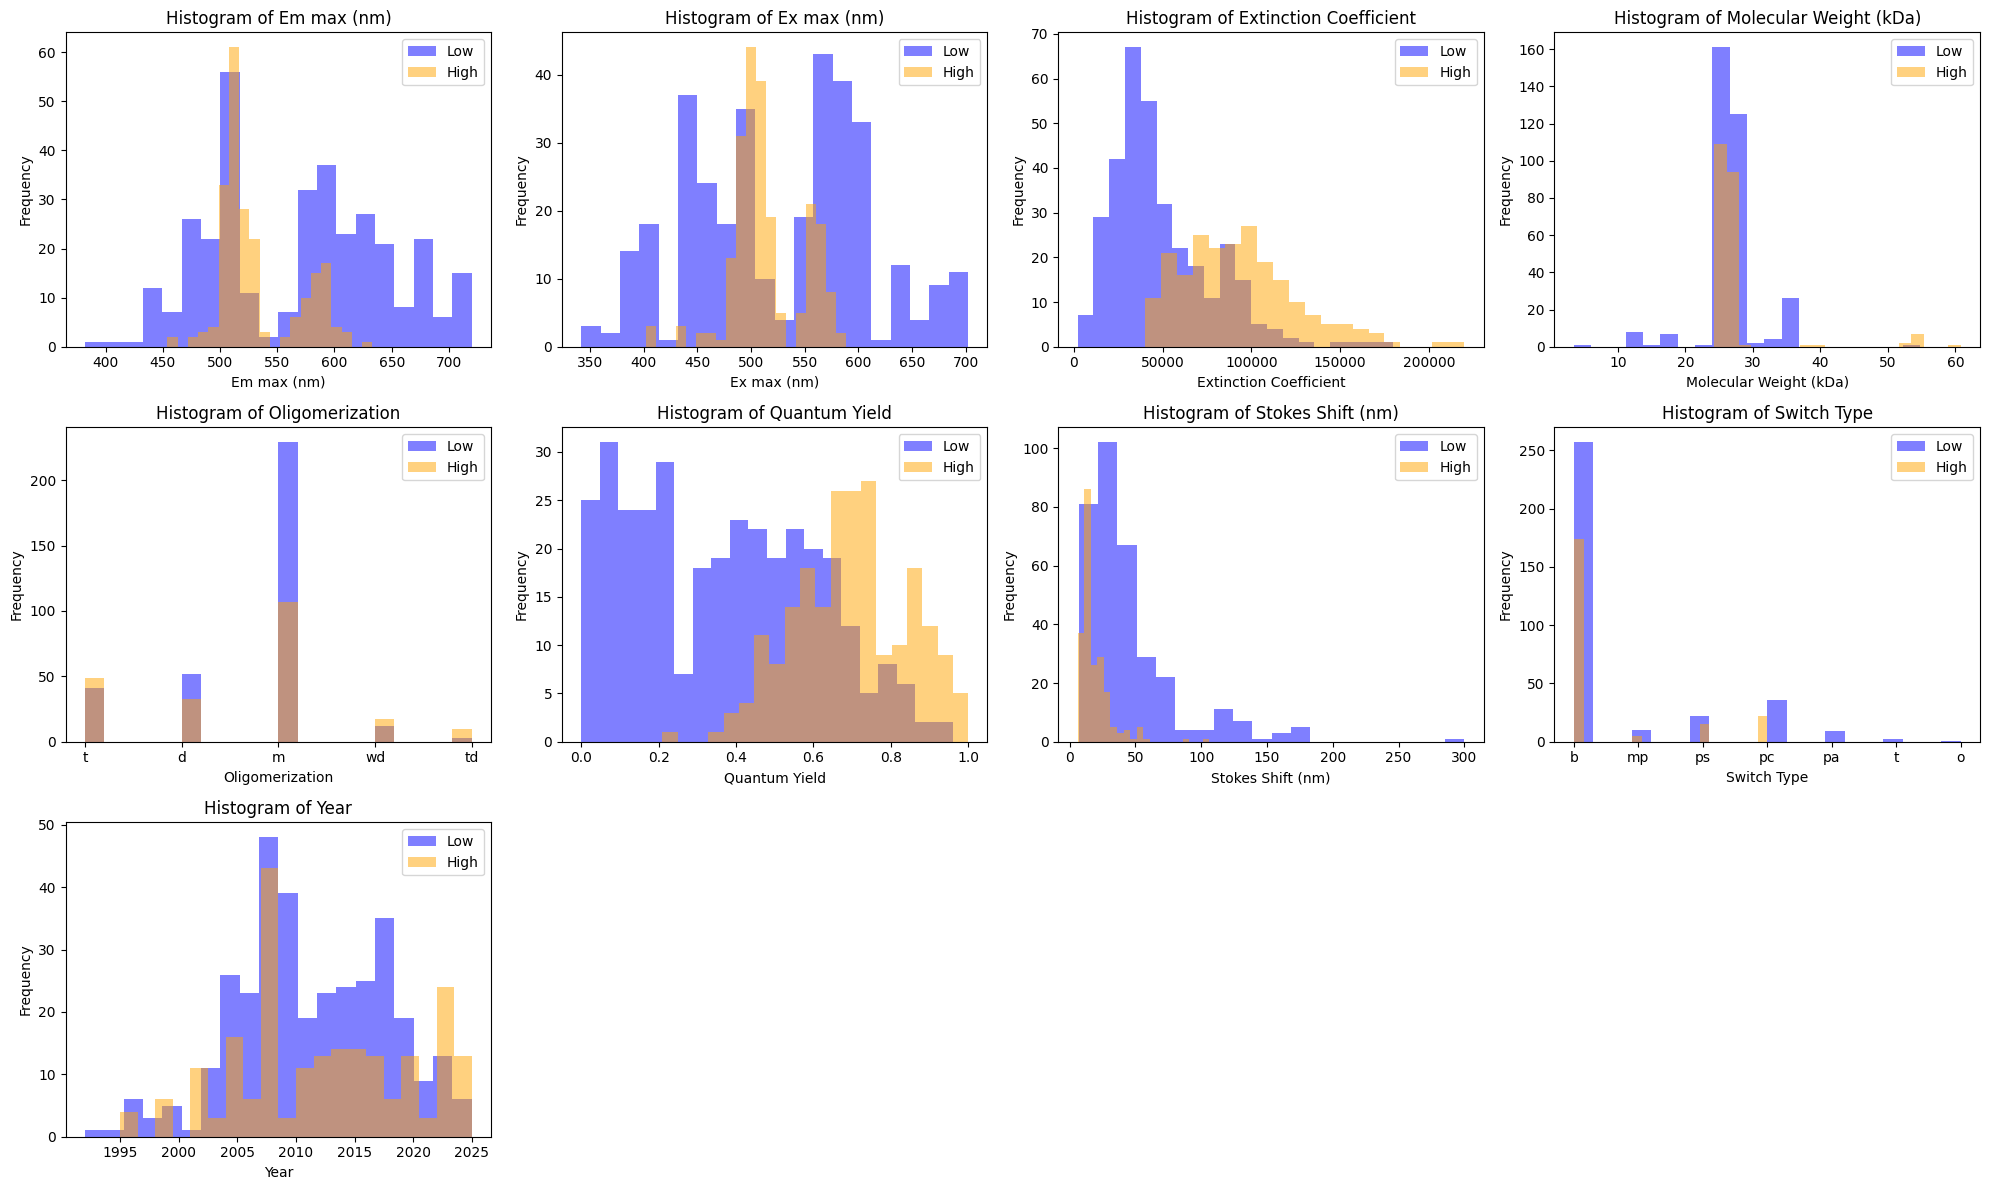

In [6]:
feature_columns = df_final.columns.difference(['Name', 'name', 'Brightness', 'Brightness Class'])
num_features = len(feature_columns)
num_cols = 4
num_rows = (num_features + num_cols - 1) // num_cols
plt.figure(figsize=(20, num_rows * 4))
for i, feature in enumerate(feature_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    for brightness_class, color in zip(['Low', 'High'], ['blue', 'orange']):
        subset = df_final[df_final['Brightness Class'] == brightness_class]
        plt.hist(subset[feature], bins=20, alpha=0.5, label=brightness_class, color=color)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()

<span style='color:blue'> 
All features have overlapping distributions between our low and high brightness classes, however some features show regions with less overlap. Extinction coefficient and quantum yield show less overlap in some regions as predicted since Brightness is calculated as the product of the two features, however, maximum emission and excitation wavelengths also appear to show less overlap in the centers of their distribution near 500 nm.
<span style>

## Initial Principle Component Analysis

As an exploratory step, Principal Component Analysis (PCA) was performed to examine how each feature contributes to variance of the 1st PC. Correlation to the Brightness feature was explored also. Continuous brightness values were used rather than the binary class labels because the constructed classes spanned over large brightness ranges simplified into “low” and “high,” which was thought to remove too much information to do a meaningful PCA and correlation analysis on.

There are limitations to this PCA, however, since the brightness values were sourced from multiple literature sources by the database which measured brightness under different experimental conditions, such as pH, which may influence reported brightness values. More analysis based on data obtained from the same experimental conditions then would be needed to increase confidence. 



Feature columns to be used:
1. Ex max (nm)
2. Em max (nm)
3. Stokes Shift (nm)
4. Extinction Coefficient
5. Quantum Yield
6. Brightness
7. Oligomerization
8. Molecular Weight (kDa)
9. Year
10. Switch Type

X matrix dimensions: (553, 10)
y vector dimensions: (553, 1)
Number of features: 10

Original data - Minimum: 0.00, Maximum: 220000.00
Scaled data - Minimum: -4.66, Maximum: 8.26


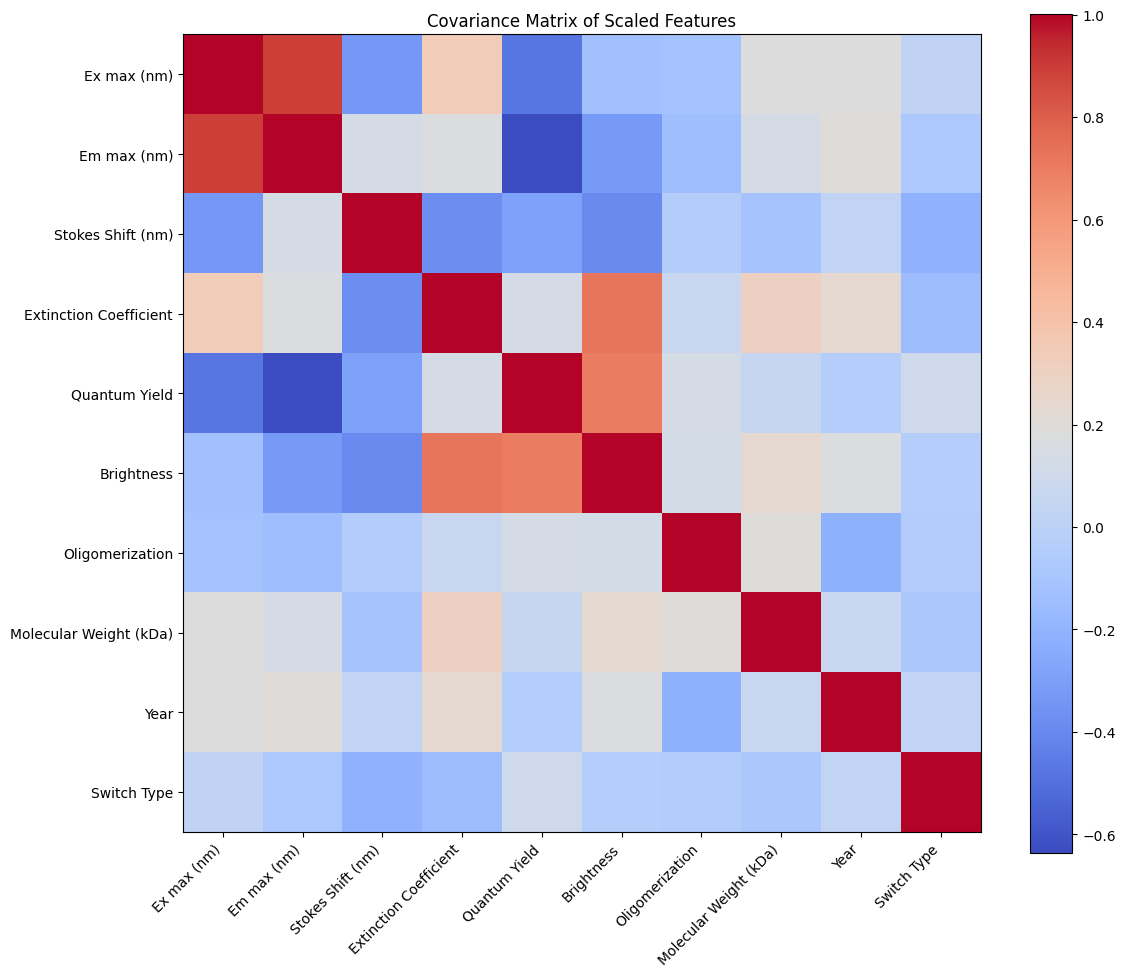


First 10 Eigenvalues: [ 2.73022963e+00  2.37036537e+00  1.26960472e+00  1.17295118e+00
 -6.78446410e-17  5.52457820e-02  3.63710582e-01  8.53595791e-01
  4.99281873e-01  6.85015074e-01]

Orthogonality check: 1.9196128045980664e-16
Orthogonality is close to zero.

Total variance: 9.999999999999996

First 10 PCs - Explained variance:
  PC1: 0.2730 (27.30%)
  PC2: 0.2370 (23.70%)
  PC3: 0.1270 (12.70%)
  PC4: 0.1173 (11.73%)
  PC5: -0.0000 (-0.00%)
  PC6: 0.0055 (0.55%)
  PC7: 0.0364 (3.64%)
  PC8: 0.0854 (8.54%)
  PC9: 0.0499 (4.99%)
  PC10: 0.0685 (6.85%)


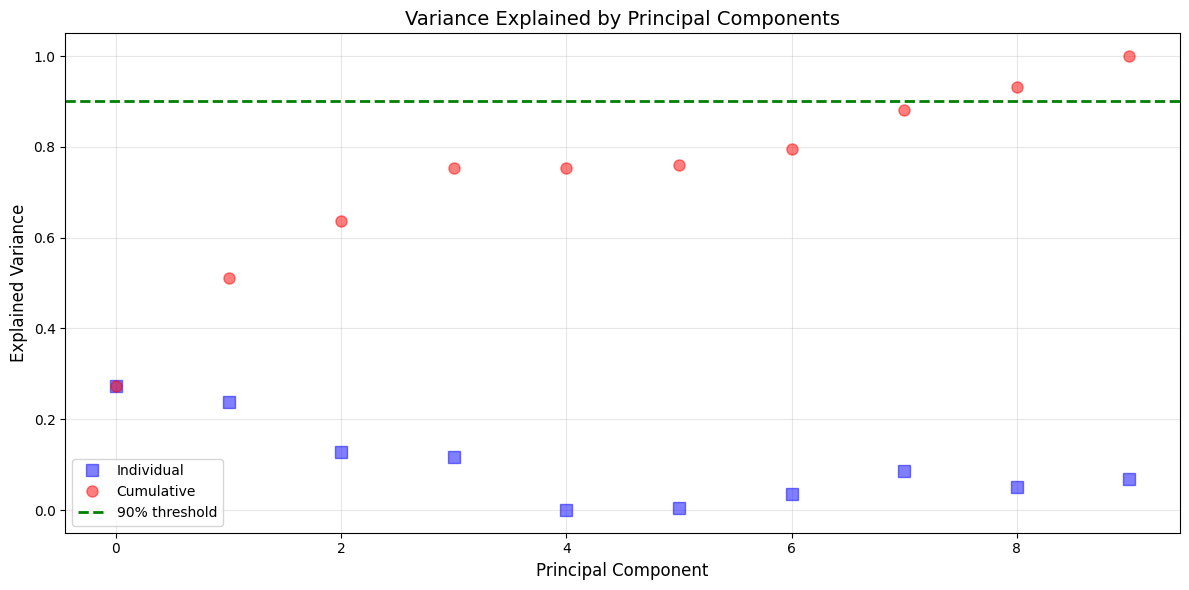


PC projection shape: (553, 10)


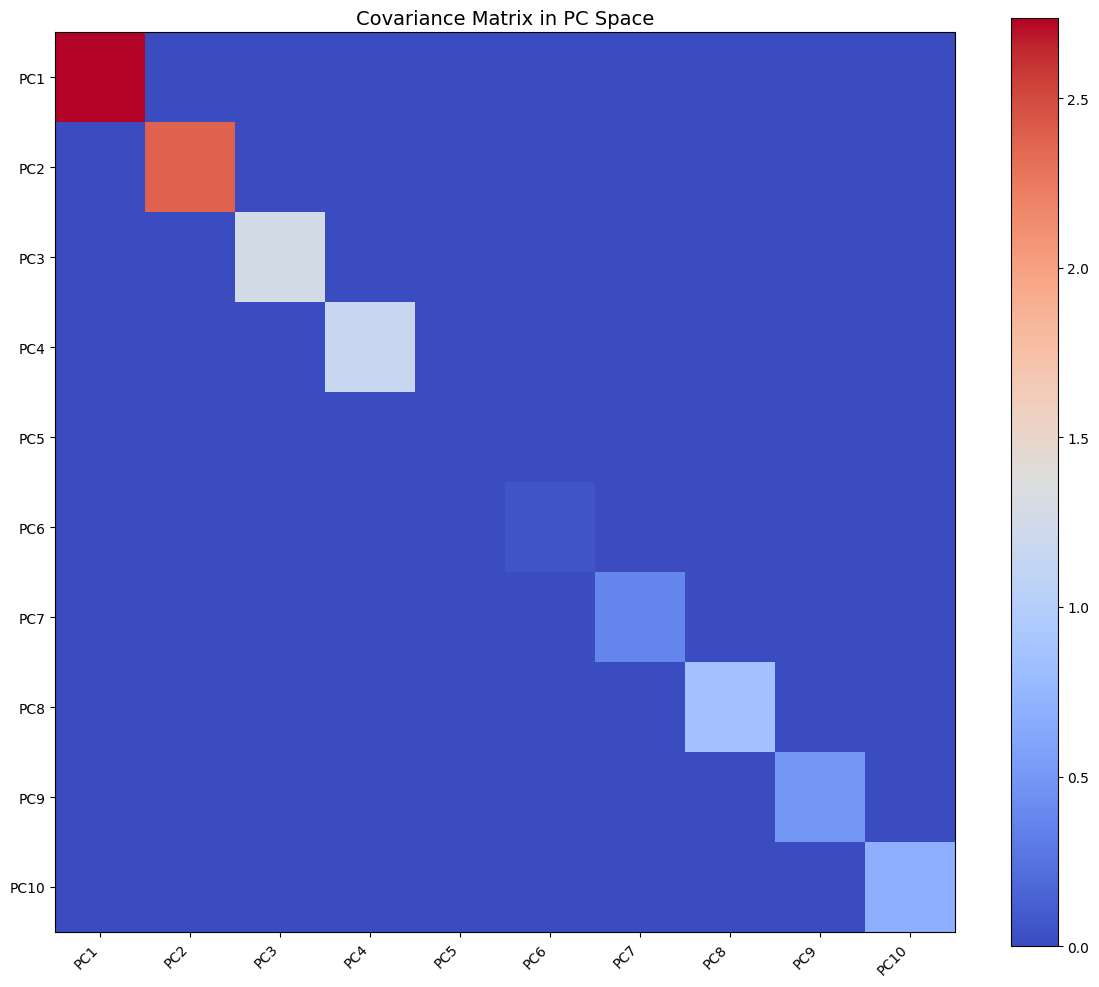

Features ranked by contribution to the first principal component: 

1. Quantum Yield
   Coefficient: +0.538013
   Absolute Value: 0.538013
   Contribution: 20.85%

2. Em max (nm)
   Coefficient: -0.490340
   Absolute Value: 0.490340
   Contribution: 19.00%

3. Brightness
   Coefficient: +0.471671
   Absolute Value: 0.471671
   Contribution: 18.28%

4. Ex max (nm)
   Coefficient: -0.366664
   Absolute Value: 0.366664
   Contribution: 14.21%

5. Stokes Shift (nm)
   Coefficient: -0.215187
   Absolute Value: 0.215187
   Contribution: 8.34%

6. Extinction Coefficient
   Coefficient: +0.175468
   Absolute Value: 0.175468
   Contribution: 6.80%

7. Oligomerization
   Coefficient: +0.165927
   Absolute Value: 0.165927
   Contribution: 6.43%

8. Molecular Weight (kDa)
   Coefficient: +0.062514
   Absolute Value: 0.062514
   Contribution: 2.42%

9. Year
   Coefficient: -0.055830
   Absolute Value: 0.055830
   Contribution: 2.16%

10. Switch Type
   Coefficient: +0.039258
   Absolute Value: 0.03

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Define the is_real_and_finite function
def is_real_and_finite(x):
    try:
        if not np.isreal(x):
            return False
        elif not np.isfinite(x):
            return False
        else:
            return True
    except:
        return False

df_work = df_final.copy()

# Encode categorical features to numeric
categorical_columns = []
if 'Oligomerization' in df_work.columns:
    le_oligo = LabelEncoder()
    df_work['Oligomerization'] = le_oligo.fit_transform(df_work['Oligomerization'].astype(str))
    categorical_columns.append('Oligomerization')

if 'Switch Type' in df_work.columns:
    le_switch = LabelEncoder()
    df_work['Switch Type'] = le_switch.fit_transform(df_work['Switch Type'].astype(str))
    categorical_columns.append('Switch Type')

# Feature columns where 'Name', 'name', 'Brightness Class' are excluded since they are not the physical properties we want to relate to compare to brightness
exclude_columns = ['Name', 'name', 'Brightness Class']
feature_columns = [col for col in df_work.columns if col not in exclude_columns]

print("\nFeature columns to be used:")
for i, col in enumerate(feature_columns, 1):
    print(f"{i}. {col}")

# Create X matrix
X = df_work[feature_columns].values.astype(float)

# Create y vector (keep as numeric, not encoded)
y = df_work['Brightness'].values.reshape(-1, 1)
    
print('\nX matrix dimensions: {}'.format(X.shape))
print('y vector dimensions: {}'.format(y.shape))
print(f'Number of features: {len(feature_columns)}')

# Standard Scaling of X 
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)
print("\nOriginal data - Minimum: {:.2f}, Maximum: {:.2f}".format(X.min(), X.max()))
print("Scaled data - Minimum: {:.2f}, Maximum: {:.2f}".format(X_scaled.min(), X_scaled.max()))

# Covariance matrix
covar = np.cov(X_scaled.T)
fig, ax = plt.subplots(figsize=(12, 10))
c = ax.imshow(covar, cmap='coolwarm')
fig.colorbar(c)
ax.set_xticks(range(len(feature_columns)))
ax.set_yticks(range(len(feature_columns)))
ax.set_xticklabels(feature_columns, rotation=45, ha='right')
ax.set_yticklabels(feature_columns)
plt.title('Covariance Matrix of Scaled Features')
plt.tight_layout()
plt.show()

# Obtaining principle component vectors from eigenvalues/eigenvectors
from scipy.linalg import eigvals, eig
corr = np.corrcoef(X.T)
eigvals_result, eigvecs = eig(corr)

print("\nFirst 10 Eigenvalues:", np.real(eigvals_result[:10]))
print("\nOrthogonality check:", np.dot(eigvecs[:, 2], eigvecs[:, 0]))
if np.isclose(np.dot(eigvecs[:, 2], eigvecs[:, 0]), 0):
    print("Orthogonality is close to zero.")

PCvals, PCvecs = eigvals_result, eigvecs
total_variance = np.sum(np.real(PCvals))
explained_variance = np.real(PCvals) / total_variance
print("\nTotal variance:", total_variance)
print("\nFirst 10 PCs - Explained variance:")
for i in range(min(10, len(explained_variance))):
    print(f"  PC{i+1}: {explained_variance[i]:.4f} ({explained_variance[i]*100:.2f}%)")

# Variance explained plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(explained_variance, 'sb', alpha=0.5, label='Individual', markersize=8)
ax.plot(np.cumsum(explained_variance), 'or', alpha=0.5, label='Cumulative', markersize=8)
ax.axhline(y=0.9, color='g', linestyle='--', label='90% threshold', linewidth=2)
ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Explained Variance', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.title('Variance Explained by Principal Components', fontsize=14)
plt.tight_layout()
plt.show()

# Project data onto PC space
PC_projection = X_scaled @ PCvecs
print("\nPC projection shape:", PC_projection.shape)

# Covariance of PCs
corr_PCs = np.cov(PC_projection.T)
fig, ax = plt.subplots(figsize=(12, 10))
c = ax.imshow(corr_PCs, cmap='coolwarm')
fig.colorbar(c)
pc_labels = [f'PC{i+1}' for i in range(len(feature_columns))]
ax.set_xticks(range(len(pc_labels)))
ax.set_yticks(range(len(pc_labels)))
ax.set_xticklabels(pc_labels, rotation=45, ha='right')
ax.set_yticklabels(pc_labels)
plt.title('Covariance Matrix in PC Space', fontsize=14)
plt.tight_layout()
plt.show()

# Rank all features contributing to first PC
first_PC_vector = PCvecs[:, 0]
abs_first_PC_vector = np.abs(first_PC_vector) 

# Sort indices by absolute value in descending order
ranked_indices = np.argsort(abs_first_PC_vector)[::-1]

print("Features ranked by contribution to the first principal component: ")
print()
for rank, idx in enumerate(ranked_indices, 1):
    feature_name = feature_columns[idx]
    feature_value = first_PC_vector[idx]
    abs_value = abs_first_PC_vector[idx]
    print(f"{rank}. {feature_name}")
    print(f"   Coefficient: {feature_value:+.6f}")
    print(f"   Absolute Value: {abs_value:.6f}")
    print(f"   Contribution: {(abs_value / abs_first_PC_vector.sum()) * 100:.2f}%")
    print()

<span style='color:blue'> 
90% of the variance in the data is explained by the first 7 principal components.

The top three features which contribute to the first principal components are quantum yield, maximum absorbed emission wavelength, and maximum absorbed excitation wavelength (excluding Brightness from our interpretation since we are investigating how other physical properties may vary with it). These are the features that vary the most in the dataset.
<span style>

## Oversampling and Standardization of Modeling Data

In [8]:
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df_work = df_final.copy()

# Encode categorical features
if 'Oligomerization' in df_work.columns:
    le_oligo = LabelEncoder()
    df_work['Oligomerization'] = le_oligo.fit_transform(df_work['Oligomerization'].astype(str))

if 'Switch Type' in df_work.columns:
    le_switch = LabelEncoder()
    df_work['Switch Type'] = le_switch.fit_transform(df_work['Switch Type'].astype(str))

# Excluding 'Name', 'name', 'Brightness', and 'Brightness Class'
exclude_columns = ['Name', 'name', 'Brightness', 'Brightness Class']
feature_columns = [col for col in df_work.columns if col not in exclude_columns]

# Create X and y
X_raw = df_work[feature_columns].values.astype(float)
y_raw = df_work['Brightness Class'].values

# Check to remove rows with NaN or inf
valid_rows = ~(np.isnan(X_raw).any(axis=1) | np.isinf(X_raw).any(axis=1))
X_clean = X_raw[valid_rows]
y_clean = y_raw[valid_rows]

# Convert to binary: High (1) vs Not-High (0)
y_binary = np.where(y_clean == 'High', 1, 0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# Oversampling the 'Low' Brightness Class

# Separate minority and majority classes
if np.sum(y_train == 1) < np.sum(y_train == 0):
    minority_class = 1
    majority_class = 0
else:
    minority_class = 0
    majority_class = 1

X_majority = X_train[y_train == majority_class]
X_minority = X_train[y_train == minority_class]
y_majority = y_train[y_train == majority_class]
y_minority = y_train[y_train == minority_class]

# Oversample minority class
X_minority_oversampled = resample(X_minority, replace=True, n_samples=len(X_majority), random_state=42)
y_minority_oversampled = resample(y_minority, replace=True, n_samples=len(y_majority), random_state=42)

# Combine and shuffle
X_train_balanced = np.vstack([X_majority, X_minority_oversampled])
y_train_balanced = np.hstack([y_majority, y_minority_oversampled])

shuffle_idx = np.random.permutation(len(y_train_balanced))
X_train_balanced = X_train_balanced[shuffle_idx]
y_train_balanced = y_train_balanced[shuffle_idx]

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

## Linear Regression Baseline

Fold 1:
  Final cost: 48.5871
  Intercept: -0.0240
  Accuracy: 0.9630
  Precision: 0.9184
  Recall: 1.0000
Fold 2:
  Final cost: 43.8143
  Intercept: -0.1526
  Accuracy: 0.9630
  Precision: 0.9683
  Recall: 0.9683
Fold 3:
  Final cost: 45.7516
  Intercept: -0.1207
  Accuracy: 0.9537
  Precision: 0.9608
  Recall: 0.9423
Fold 4:
  Final cost: 40.2803
  Intercept: 0.0127
  Accuracy: 0.9533
  Precision: 0.9483
  Recall: 0.9649
Fold 5:
  Final cost: 41.3766
  Intercept: -0.2320
  Accuracy: 0.9065
  Precision: 0.8889
  Recall: 0.9231

Cross-Validation Summary:
Average Cost: 43.9620 (+/- 2.9952)
Average Accuracy: 0.9479 (+/- 0.0211)
Average Precision: 0.9369 (+/- 0.0294)
Average Recall: 0.9597 (+/- 0.0260)

Final Model Training on Full Training Set
Logistic Regression Test Accuracy: 0.38738738738738737
Test Precision: 0.38738738738738737
Test Recall: 1.0


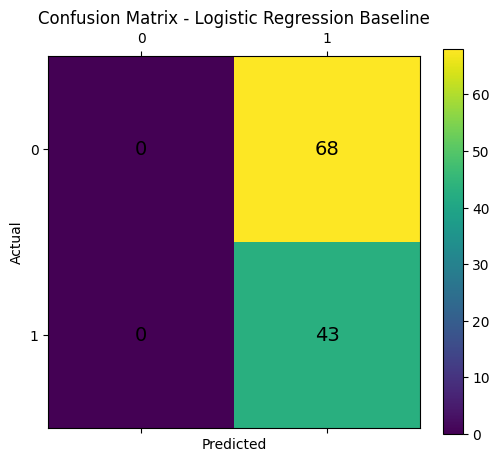

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from scipy.optimize import minimize

# Linear Regression Model Functions
def add_intercept(X):
    return np.hstack([np.ones((X.shape[0], 1)), X])

def softmax_cost(w, X, y):
    X_i = add_intercept(X)
    Xb = np.dot(X_i, w)
    y_signed = 2 * y - 1
    exp_term = np.exp(-y_signed * Xb)
    return np.sum(np.log(1 + exp_term))

def linear_classifier(X, w):
    X_i = add_intercept(X)
    scores = np.dot(X_i, w)
    # Return 1 for positive scores, 0 for negative scores
    return (scores >= 0).astype(int)


# Kfold folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Storage for metrics across folds
acc_scores = []
prec_scores = []
rec_scores = []
all_weights = []
all_costs = []



for fold, (train_index, test_index) in enumerate(kf.split(X_train_scaled), 1):
    # Split data for this fold
    X_fold_train, X_fold_test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_test = y_train_balanced[train_index], y_train_balanced[test_index]
    
    # Train model on this fold
    w_init = np.zeros(X_fold_train.shape[1] + 1)
    result = minimize(softmax_cost, w_init, args=(X_fold_train, y_fold_train))
    w_fold = result.x
    
    # Predict on fold test set
    y_pred_fold = linear_classifier(X_fold_test, w_fold)
    
    # Calculate metrics
    acc = accuracy_score(y_fold_test, y_pred_fold)
    prec = precision_score(y_fold_test, y_pred_fold, pos_label=1, zero_division=0)
    rec = recall_score(y_fold_test, y_pred_fold, pos_label=1, zero_division=0)
    
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    all_weights.append(w_fold)
    all_costs.append(result.fun)
    
    print(f"Fold {fold}:")
    print(f"  Final cost: {result.fun:.4f}")
    print(f"  Intercept: {w_fold[0]:.4f}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}")

# Summary statistics
print("\nCross-Validation Summary:")
print(f"Average Cost: {np.mean(all_costs):.4f} (+/- {np.std(all_costs):.4f})")
print(f"Average Accuracy: {np.mean(acc_scores):.4f} (+/- {np.std(acc_scores):.4f})")
print(f"Average Precision: {np.mean(prec_scores):.4f} (+/- {np.std(prec_scores):.4f})")
print(f"Average Recall: {np.mean(rec_scores):.4f} (+/- {np.std(rec_scores):.4f})")

# Train final model on full training set
print("\nFinal Model Training on Full Training Set")

w_init = np.zeros(X_train_scaled.shape[1] + 1)
result = minimize(softmax_cost, w_init, args=(X_train_scaled, y_train_balanced))
w_logit = result.x
y_pred_train = linear_classifier(X_train_scaled, w_logit)


# Test set evaluation
y_pred = linear_classifier(X_test_scaled, w_logit)

# Test metrics
acc_test = accuracy_score(y_test, y_pred)
prec_test = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
rec_test = recall_score(y_test, y_pred, pos_label=1, zero_division=0)

print("Logistic Regression Test Accuracy:", acc_test)
print("Test Precision:", prec_test)
print("Test Recall:", rec_test)

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.matshow(cm)
plt.title("Confusion Matrix - Logistic Regression Baseline")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar(cax)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], va='center', ha='center', fontsize=14)

plt.show()

<span style='color:blue'> 
The baseline logistic regression model experiences a drop in accuracy from the training data prediction accuracy, 94.79%, to the test data prediction accuracy, 38.74%. This suggests there is strong overfitting to the train dataset. An initial 94.79% accuracy suggests a large amount of the training data could be separated linearly, however, accuracy on new test data could be improved by nonlinear methods. 

<span style>

In [10]:
x_names = feature_columns

# Extract feature weights (excluding intercept)
feature_weights = w_logit[1:]  # skip w_logit[0] (intercept)

# Create DataFrame with feature names and weights
weights_df = pd.DataFrame({
    'Feature': x_names,
    'Weight': feature_weights,
    'Abs_Weight': np.abs(feature_weights)
}).sort_values(by='Abs_Weight', ascending=False)

# Display ranked features
print("Rank of Features In Order of Importance\n")
print(weights_df[['Feature', 'Weight']].to_string(index=False))

Rank of Features In Order of Importance

               Feature    Weight
         Quantum Yield  7.183835
Extinction Coefficient  6.169704
     Stokes Shift (nm) -1.557999
Molecular Weight (kDa)  1.416658
           Ex max (nm)  0.715871
                  Year -0.450665
           Switch Type -0.448933
       Oligomerization  0.137271
           Em max (nm)  0.021850


<span style='color:blue'> 
Quantum yield and extinction coefficient most influence the linear regression model's decision boundaries represented by the higher magnitude weights. The next three most influential features are Stokes Shift, molecular weight, and maximum absorbed excitation wavelength, suggesting they may be interesting physical properties to look at in fluorescent proteins for increasing brightness.
<span style>

## KNN

Fold 1:
  Best Params: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
  Accuracy: 0.8889
  Precision: 0.8276
  Recall: 0.9600

Fold 2:
  Best Params: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
  Accuracy: 0.9537
  Precision: 0.9200
  Recall: 0.9787

Fold 3:
  Best Params: {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
  Accuracy: 0.9074
  Precision: 0.8852
  Recall: 0.9474

Fold 4:
  Best Params: {'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
  Accuracy: 0.9533
  Precision: 0.9375
  Recall: 0.9836

Fold 5:
  Best Params: {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
  Accuracy: 0.9626
  Precision: 0.9310
  Recall: 1.0000


Cross-Validation Summary:
Average Accuracy: 0.9332 (+/- 0.0294)
Average Precision: 0.9003 (+/- 0.0406)
Average Recall: 0.9739 (+/- 0.0184)

Final Model Training on Full Training Set
Best Params: {'n_neighbors': 11, 'p': 2, 'weights': 'distance'}
Test Accuracy: 0.9369
Test Precision: 0.8750
Test Recall: 0.9767


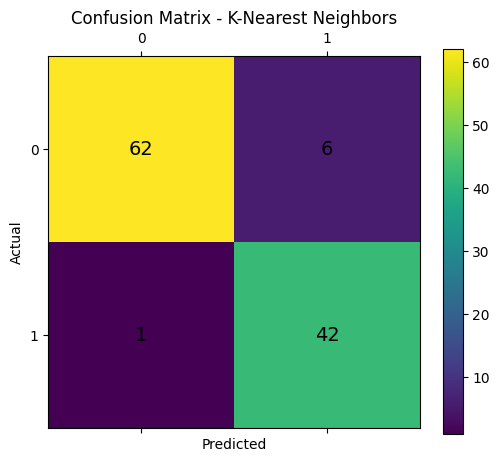

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Kfold folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define KNN and parameter grid
knn = KNeighborsClassifier()
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 11, 15],
    'weights': ['distance'],
    'p': [1, 2]   # Manhattan (1) and Euclidean (2)
}

# Storage for metrics across folds
acc_scores = []
prec_scores = []
rec_scores = []
all_best_params = []

for fold, (train_index, test_index) in enumerate(kf.split(X_train_scaled), 1):
    # Split data for this fold
    X_fold_train, X_fold_test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_test = y_train_balanced[train_index], y_train_balanced[test_index]
    
    # Grid search on this fold
    grid_knn = GridSearchCV(knn, param_grid_knn, cv=3)  # Inner CV for hyperparameter tuning
    grid_knn.fit(X_fold_train, y_fold_train)
    
    # Best model for this fold
    knn_best = grid_knn.best_estimator_
    y_pred_knn = knn_best.predict(X_fold_test)
    
    # Calculate metrics
    acc = accuracy_score(y_fold_test, y_pred_knn)
    prec = precision_score(y_fold_test, y_pred_knn, pos_label=1)
    rec = recall_score(y_fold_test, y_pred_knn, pos_label=1)
    
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    all_best_params.append(grid_knn.best_params_)
    
    print(f"Fold {fold}:")
    print(f"  Best Params: {grid_knn.best_params_}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}\n")

# Summary statistics
print("\nCross-Validation Summary:")
print(f"Average Accuracy: {np.mean(acc_scores):.4f} (+/- {np.std(acc_scores):.4f})")
print(f"Average Precision: {np.mean(prec_scores):.4f} (+/- {np.std(prec_scores):.4f})")
print(f"Average Recall: {np.mean(rec_scores):.4f} (+/- {np.std(rec_scores):.4f})")

# Train final model on full training set with most common best params
grid_knn_final = GridSearchCV(knn, param_grid_knn, cv=5)
grid_knn_final.fit(X_train_scaled, y_train_balanced)
knn_best_final = grid_knn_final.best_estimator_

# Evaluate on test set
y_pred_knn_final = knn_best_final.predict(X_test_scaled)
acc_final = accuracy_score(y_test, y_pred_knn_final)
prec_final = precision_score(y_test, y_pred_knn_final, pos_label=1)
rec_final = recall_score(y_test, y_pred_knn_final, pos_label=1)

print("\nFinal Model Training on Full Training Set")
print("Best Params:", grid_knn_final.best_params_)
print(f"Test Accuracy: {acc_final:.4f}")
print(f"Test Precision: {prec_final:.4f}")
print(f"Test Recall: {rec_final:.4f}")

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred_knn_final)
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.matshow(cm)
plt.title("Confusion Matrix - K-Nearest Neighbors")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar(cax)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], va='center', ha='center', fontsize=14)

plt.show()

<span style='color:blue'> 
The KNN model experiences comparable accuracy from training data accuracy, 93.32%, to test data accuracy, 93.69%. However, precision, experiences a decrease from 90.03% to 87.50%.  This suggests the KNN model may experience some overfitting to the training data more than the baseline logistic regression model. KNN makes predictions by memorizing the classes of nearby data around a training data point rather than learning a pattern, so this may explain why its precision decreases in the test dataset where neighborhoods around points may be different, especially for this data. The 'High' brightness protein class contains a wide range of brightness values from 33.5 to 164 so this may make the class likely diverse in other physical properties as well and local neighborhoods more diverse across shuffles.
<span style>

## Support Vector Machines

Fold 1:
  Best Params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
  Accuracy: 0.9722
  Precision: 0.9434
  Recall: 1.0000

Fold 2:
  Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
  Accuracy: 0.9444
  Precision: 0.9020
  Recall: 0.9787

Fold 3:
  Best Params: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
  Accuracy: 0.9722
  Precision: 1.0000
  Recall: 0.9474

Fold 4:
  Best Params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
  Accuracy: 0.9720
  Precision: 1.0000
  Recall: 0.9508

Fold 5:
  Best Params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
  Accuracy: 0.9626
  Precision: 0.9310
  Recall: 1.0000


Cross-Validation Summary:
Average Accuracy: 0.9647 (+/- 0.0108)
Average Precision: 0.9553 (+/- 0.0389)
Average Recall: 0.9754 (+/- 0.0229)

Final Model (trained on full training set):
Best Params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Test Accuracy: 0.9369
Test Precision: 0.9737
Test Recall: 0.8605


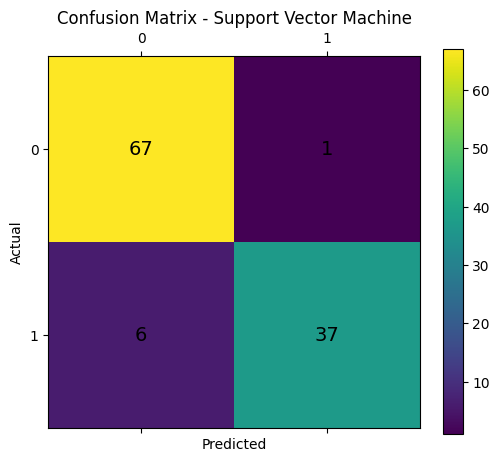

In [12]:
from sklearn.svm import SVC

# Kfold folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define SVM and parameter grid
svm = SVC()
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': ['scale', 'auto']
}

# Storage for metrics across folds
acc_scores = []
prec_scores = []
rec_scores = []
all_best_params = []

for fold, (train_index, test_index) in enumerate(kf.split(X_train_scaled), 1):
    # Split data for this fold
    X_fold_train, X_fold_test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_test = y_train_balanced[train_index], y_train_balanced[test_index]
    
    # Grid search on this fold
    grid_svm = GridSearchCV(svm, param_grid_svm, cv=3)  # Inner CV for hyperparameter tuning
    grid_svm.fit(X_fold_train, y_fold_train)
    
    # Best model for this fold
    svm_best = grid_svm.best_estimator_
    y_pred_svm = svm_best.predict(X_fold_test)
    
    # Calculate metrics
    acc = accuracy_score(y_fold_test, y_pred_svm)
    prec = precision_score(y_fold_test, y_pred_svm, pos_label=1)
    rec = recall_score(y_fold_test, y_pred_svm, pos_label=1)
    
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    all_best_params.append(grid_svm.best_params_)
    
    print(f"Fold {fold}:")
    print(f"  Best Params: {grid_svm.best_params_}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}\n")

# Summary statistics
print("\nCross-Validation Summary:")
print(f"Average Accuracy: {np.mean(acc_scores):.4f} (+/- {np.std(acc_scores):.4f})")
print(f"Average Precision: {np.mean(prec_scores):.4f} (+/- {np.std(prec_scores):.4f})")
print(f"Average Recall: {np.mean(rec_scores):.4f} (+/- {np.std(rec_scores):.4f})")

# Train final model on full training set
grid_svm_final = GridSearchCV(svm, param_grid_svm, cv=5)
grid_svm_final.fit(X_train_scaled, y_train_balanced)
svm_best_final = grid_svm_final.best_estimator_

# Evaluate on test set
y_pred_svm_final = svm_best_final.predict(X_test_scaled)
acc_final = accuracy_score(y_test, y_pred_svm_final)
prec_final = precision_score(y_test, y_pred_svm_final, pos_label=1)
rec_final = recall_score(y_test, y_pred_svm_final, pos_label=1)

print("\nFinal Model (trained on full training set):")
print("Best Params:", grid_svm_final.best_params_)
print(f"Test Accuracy: {acc_final:.4f}")
print(f"Test Precision: {prec_final:.4f}")
print(f"Test Recall: {rec_final:.4f}")

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred_svm_final)
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.matshow(cm)
plt.title("Confusion Matrix - Support Vector Machine")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar(cax)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], va='center', ha='center', fontsize=14)

plt.show()

<span style='color:blue'> 
The Support Vector Machines model performed less accurately, 93.69%, on the testing data than on the training data, 96.47% accuracy average, suggesting that the model overfitted to training data. In contrast to the KNN model, the SVM model does learn a non-linear boundary and seekes to minimize a weight function which is inversely proportional the margins around the boundary. Precision in the SVM model is much higher, however, suggesting it is less prone to making false negatives.
<span style>

## XGBoost

Fold 1:
  Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000

Fold 2:
  Best Params: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
  Accuracy: 0.9907
  Precision: 0.9792
  Recall: 1.0000

Fold 3:
  Best Params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
  Accuracy: 0.9630
  Precision: 1.0000
  Recall: 0.9298

Fold 4:
  Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
  Accuracy: 0.9720
  Precision: 0.9531
  Recall: 1.0000

Fold 5:
  Best Params: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
  Accuracy: 0.9720
  Precision: 0.9474
  Recall: 1.0000


Cross-Validation Summary:
Average Accuracy: 0.9795 (+/- 0.0137)
Average Precision: 0.9759 (+/- 0.0224)
Average Recall: 0.9860 (+/- 0.0281)

Final Model (trained on full training set):
Best Params: {'learning_ra

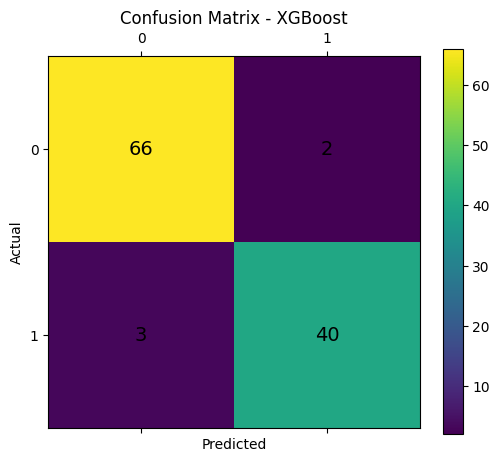

In [14]:
from xgboost import XGBClassifier

# Kfold folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define XGBoost and parameter grid
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

# Storage for metrics across folds
acc_scores = []
prec_scores = []
rec_scores = []
all_best_params = []

for fold, (train_index, test_index) in enumerate(kf.split(X_train_scaled), 1):
    # Split data for this fold
    X_fold_train, X_fold_test = X_train_scaled[train_index], X_train_scaled[test_index]
    y_fold_train, y_fold_test = y_train_balanced[train_index], y_train_balanced[test_index]
    
    # Grid search on this fold
    grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3)  # Inner CV for hyperparameter tuning
    grid_xgb.fit(X_fold_train, y_fold_train)
    
    # Best model for this fold
    xgb_best = grid_xgb.best_estimator_
    y_pred_xgb = xgb_best.predict(X_fold_test)
    
    # Calculate metrics
    acc = accuracy_score(y_fold_test, y_pred_xgb)
    prec = precision_score(y_fold_test, y_pred_xgb, pos_label=1)
    rec = recall_score(y_fold_test, y_pred_xgb, pos_label=1)
    
    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    all_best_params.append(grid_xgb.best_params_)
    
    print(f"Fold {fold}:")
    print(f"  Best Params: {grid_xgb.best_params_}")
    print(f"  Accuracy: {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall: {rec:.4f}\n")

# Summary statistics
print("\nCross-Validation Summary:")
print(f"Average Accuracy: {np.mean(acc_scores):.4f} (+/- {np.std(acc_scores):.4f})")
print(f"Average Precision: {np.mean(prec_scores):.4f} (+/- {np.std(prec_scores):.4f})")
print(f"Average Recall: {np.mean(rec_scores):.4f} (+/- {np.std(rec_scores):.4f})")

# Train final model on full training set
grid_xgb_final = GridSearchCV(xgb, param_grid_xgb, cv=5)
grid_xgb_final.fit(X_train_scaled, y_train_balanced)
xgb_best_final = grid_xgb_final.best_estimator_

# Evaluate on test set
y_pred_xgb_final = xgb_best_final.predict(X_test_scaled)
acc_final = accuracy_score(y_test, y_pred_xgb_final)
prec_final = precision_score(y_test, y_pred_xgb_final, pos_label=1)
rec_final = recall_score(y_test, y_pred_xgb_final, pos_label=1)

print("\nFinal Model (trained on full training set):")
print("Best Params:", grid_xgb_final.best_params_)
print(f"Test Accuracy: {acc_final:.4f}")
print(f"Test Precision: {prec_final:.4f}")
print(f"Test Recall: {rec_final:.4f}")

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred_xgb_final)
fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.matshow(cm)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar(cax)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], va='center', ha='center', fontsize=14)

plt.show()

<span style='color:blue'> 
The XGBoost model reports the highest accuracy, 95.50%, on the test data among the models tested. However, a decrease in accuracy from training data predictions to test data predictions does suggest overfitting similar to the other models. XGBoost takes an ensemble of weak decision trees and learns from the mistakes of each prior tree. This allows it to select weigh certain features more than others, whereas, the KNN model simply memorizes based on class. The element of gaining accuracy through repeated, or iterative, learning may cause XGBoost to be a stronger nonlinear method than SVM.
<span style>

# Conclusions: (15 points)

* Compare your results to other models on the same data in the literature or on websites. (5)
* State your conclusions based on the results.  Relate back to the goal you posed in the introduction. (5)
* Given more time or data what would you try next to improve your model(s), or if it already works well how would you extend it to other datasets? (5)

<span style='color:blue'> 
Other models use the dataset to explore relationships with sequence, whereas this project explores just relationships with physical properties. To explore sequence-function relationships, Ji, et al. (2025) uses a method that predicts protein brightness based on certain residue properties at different positions in the sequence, which positions serve as the set of features for the model. For this, >100 fluorescent proteins of similar lineage were sequenced and submitted for multiple sequence alignment to obtain ~200 aligned positions to use as features. XGBoost and SVM, among other model types, were used to identify amino acid positions which correlated with bright proteins by nonlinear regression. The amino acid identity, however, had to be encoded to more general amino acid properties/descriptors using the AAIndex database. Each position was simulated to have mutations with each of the 20 amino acids, and the mutation was predicted by the model for its effect on protein brightness among other fluorescence properties studied. Time as well as data access constraints prevented this project from replicating the scope of these studies. 
Ji, et al. (2025) does report similarly to the results of this project that non-linear methods were well suited for fluorescent protein brightness classification tasks, and tree-based models outperformed KNN and SVR models. Performance metrics were not reported, however, XGBoost among other tree-based models were chosen among the top performing models to be used in later experiments. 
<br>
<br>
Principal Component Analysis suggested that quantum yield, emission maximum, and excitation maximum are the features that greatly capture variance in this dataset. The linear regression model was most influenced by features quantum yield, extinction coefficient, Stokes Shift, molecular weight, and excitation wavelength maximum. This suggests emission maximum (strong PCA contribution, but weak regression model influence) may add noise to data variance, while quantum yield and excitation maximum may be good brightness class discriminators. Quantum yield makes intuitive sense in that a higher efficiency of emitted light yield from absorbed light corresponds to a brighter fluorescent protein. Maximum emission wavelength had a negative coefficient in linear model weight ranking, suggesting that longer emitted wavelengths tended to correspond to lower brightness. This translates to blue and green fluorescent proteins being brighter than red-shifted proteins in this dataset. This aligns with the current direction of research to develop red-shifted proteins that are brighter to be used in imaging since red-shifted proteins confer advantages like greater depth of tissue penetration with their longer wavelength, but lack the same brightness. From the models tested (linear regression, KNN, SVM, and XGBoost), the XGBoost model performed with greatest accuracy while KNN and SVM performed with similar test data accuracy, both higher than linear regression.
<br>
<br>
Given more data, a greater number of classes could improve the models. Currently the data are divided between binary classes of low and high brightness, however, the ‘High’ brightness class covers a very wide range of FPBase brightness values from 34 to 164. Subdividing the classes (e.g. low, medium, and high) could provide more specific brightness predictions, however, the current dataset becomes sparse when subdivided. Since brightness was originally reported numerical value (not as a class) as a direct regression may also provide more specific and useful predictions. A classification task was chosen for this current dataset because brightness values are also prone to vary due to different protein conditions and measurement methods from the literature it is reported from (which FPBase warns in its description of the ‘Brightness’ feature). Data where brightness values were all experimentally obtained similarly could allow for direct regression. With more time, perhaps these models could be compared to models that train excluding the Extinction Coefficient and Quantum Yield features since they are already known to relate to Brightness in the given definition of it. Are the other physical properties sufficient to predict brightness? Lastly, these models could improve with the incorporation of sequence data as described above as recent literature does. Identifying positions strongly correlated with brightness could provide useful insight to the efforts in rational mutagenesis of fluorescent proteins, where site-directed mutagenesis can induce favorable changes rather than through countless random mutagenesis and screening.
<span style>

# References

(1) Lambert, TJ (2019) FPbase: a community-editable fluorescent protein database. Nature Methods. 16, 277–278. doi: 10.1038/s41592-019-0352-8

(2) Cranfill, P. J.; Sell, B. R.; Baird, M. A.; Allen, J. R.; Lavagnino, Z.; de Gruiter, H. M.; Kremers, G.-J.; Davidson, M. W.; Ustione, A.; Piston, D. W. Quantitative Assessment of Fluorescent Proteins. Nat Methods 2016, 13 (7), 557–562. https://doi.org/10.1038/nmeth.3891.

(3) Alley, E. C.; Khimulya, G.; Biswas, S.; AlQuraishi, M.; Church, G. M. Unified Rational Protein Engineering with Sequence-Based Deep Representation Learning. Nat Methods 2019, 16 (12), 1315–1322. https://doi.org/10.1038/s41592-019-0598-1.
